# Imports

In [40]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Data

In [41]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255
y = train_df['label'].values

X_test = test_df.values.reshape(-1, 28,28) / 255

# Generator

In [42]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 10)        100         label_input[0][0]                
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 10)           0           embedding_4[0][0]                
__________________________________________________________________________________________________
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
concatenat

# Discriminator

In [43]:
discriminator = Sequential()
discriminator.add(Reshape((28,28,1),input_shape=(28,28)))
discriminator.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))    
discriminator.add(Flatten())
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dense(11, activation='softmax'))
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
__________

# GAN

In [45]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 28, 28)       789221      latent_input[0][0]               
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 11)           131019      model_7[1][0]                    
Total para

In [46]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [47]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

In [48]:
save_interval = 500
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))
    
    discriminator.trainable=False
    
    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels}, 
                       gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=2.4007136821746826. acc=0.10000000149011612
discriminator: loss_real=2.421771287918091, acc_real=0.05000000074505806
    loss_fake=2.4293782711029053, acc_fake=0.0
generator: loss=10.400886535644531. acc=0.0
discriminator: loss_real=0.058874912559986115, acc_real=1.0
    loss_fake=0.04649762809276581, acc_fake=0.949999988079071
generator: loss=3.331267833709717. acc=0.05000000074505806
discriminator: loss_real=0.2872597873210907, acc_real=0.949999988079071
    loss_fake=0.3680339753627777, acc_fake=0.8999999761581421
generator: loss=2.556694746017456. acc=0.20000000298023224
discriminator: loss_real=0.6154022216796875, acc_real=0.75
    loss_fake=0.6259752511978149, acc_fake=0.6499999761581421
generator: loss=2.5626769065856934. acc=0.05000000074505806
discriminator: loss_real=1.4431064128875732, acc_real=0.6499999761581421
    loss_fake=0.32854145765304565, acc_fake=0.8999999761581421
generator: loss=3.341249942779541. acc=0.05000000074505806
discriminator: loss_real=0

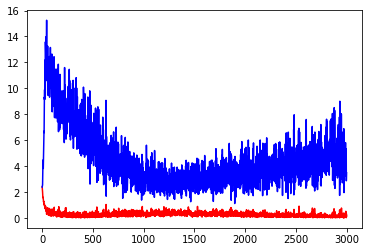

In [49]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

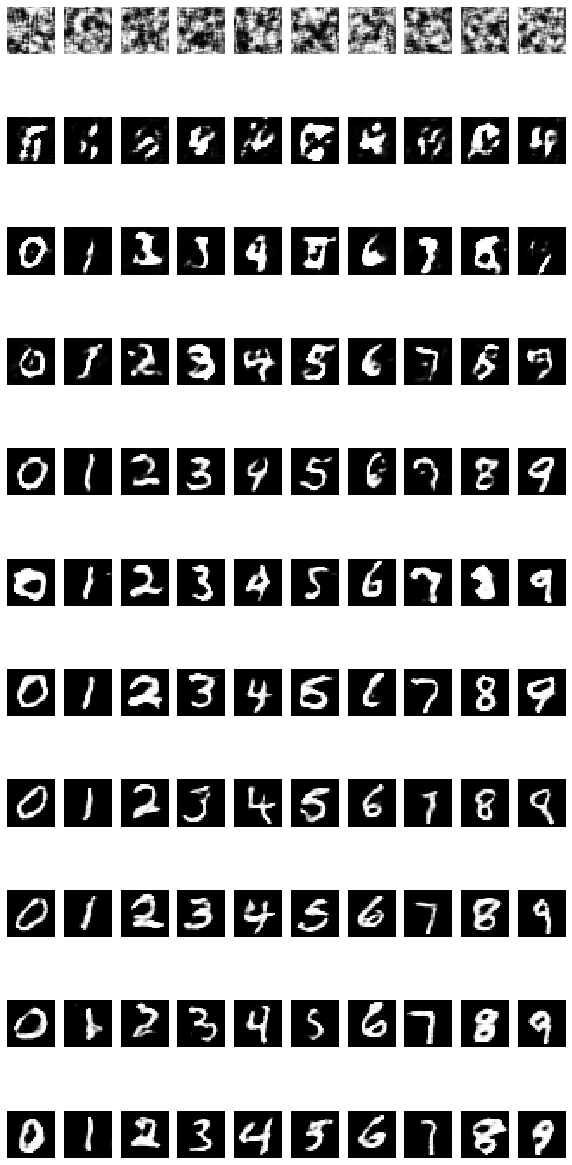

In [50]:
checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

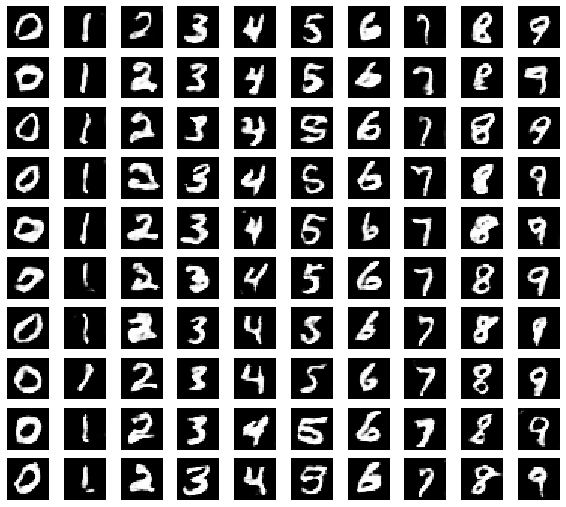

In [51]:
generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')